In [1]:
### Denoising Diffusion Probabilistic Models
### Diffusion Models Beat GANs on Image Synthesis

### the implementaiton of basic diffusion model

### import libraries
import torch
import torch.nn.functional as F


In [2]:
## define beta schedule

def linear_beta_schedule(timesteps, start = 0.0001, end = 0.02):
    #one-dimensional tensor of size steps whose values are evenly spaced from start to end
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension
    """
    # number of samples we use to train nn in one epoch, usually fit gpu memory so 32
    batch_size = t.shape[0]
    # out = vals.gather(-1, t.cuda())
    out = vals.gather(-1, t.cpu())

    # return out.reshape(batch_size, *((-1:) * (len(x_shape) -1))).to(t.device)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

## main function
# used_device = "cuda" if torch.cuda.is_available() else "CPU"
# print(used_device)
# def forward_diffusion_sample(x_0, t, device= used_device):
def forward_diffusion_sample(x_0, t, device= "cpu"):

    # print(used_device)

    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution
    noise = torch.randn_like(x_0)
    # noise from distributions
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device)\
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


In [3]:
## Define beta schedule
T = 200
betas = linear_beta_schedule(timesteps = T)

## Pre-calculate differnet terms for closed form
alphas = 1. - betas

#Returns the cumulative product of elements of input in the dimension dim
alphas_cumprod = torch.cumprod(alphas, axis = 0)

alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. -alphas_cumprod_prev) / (1. - alphas_cumprod)


In [4]:
### test it on dataset

### import library for data loader
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# initial settings
IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    # list of transforms
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t *2) -1) # Scale between [-1, 1]
    ]
    # Composes several transforms together.
    data_transform = transforms.Compose(data_transforms)
    # apply the transforms
    #data = torchvision.datasets.StanfordCars(root="./", download=True)
    train = torchvision.datasets.StanfordCars(root ="./", download = True,
                                            transform = data_transform)

    test = torchvision.datasets.StanfordCars(root ="./", download = True, transform = data_transform, split = "test")

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t+1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),   # CHW to HWC,  Returns a view of the original tensor input with its dimensions permuted. diemnsion[2, 3, 5] -> diemnsion[5, 2, 3] (shift one)
        transforms.Lambda(lambda t: t * 255),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ]
    )

    # take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
# print(data[0])
# print(len(data))
dataloader = DataLoader(data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

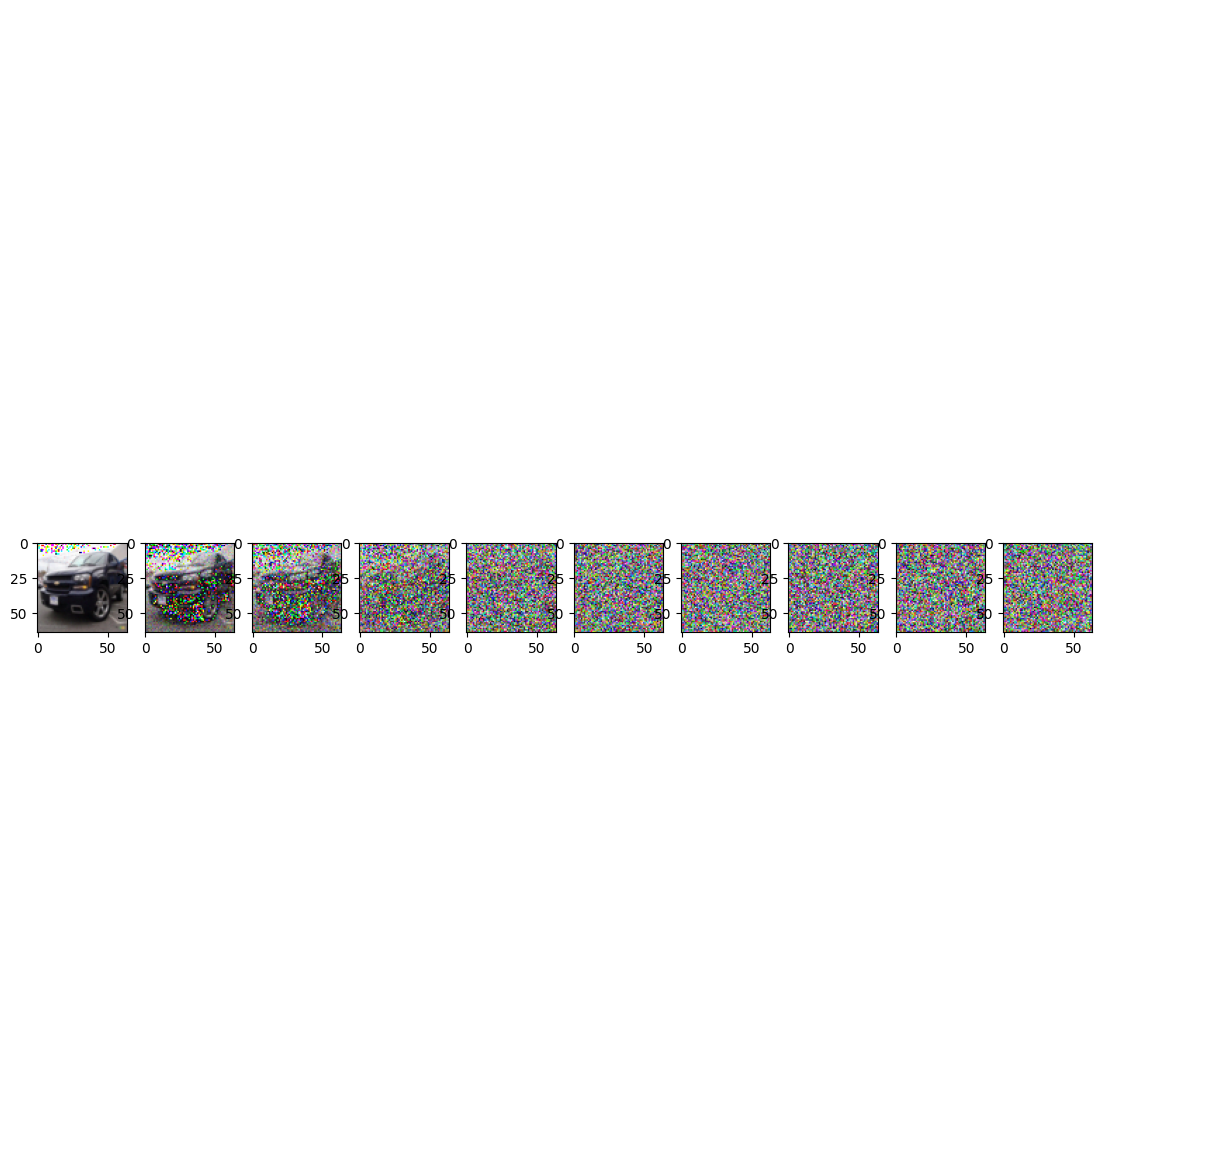

In [6]:
### simulate forward diffusion for one batch

image = next(iter(dataloader))[0]

plt.figure(figsize = (15, 15))
plt.axis("off")
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    # print((idx/stepsize) +1)
    plt.subplot(1, num_images +1, int((idx/stepsize) +1))
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)